[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablocalvo7/Equivariance_Seeker_Model/blob/main/notebook_equivariance_seeker_model.ipynb)

---

**Learning finite symmetry groups of dynamical systems via equivariance detection**
---
Pablo Calvo-Barlés,$^{1, 2}$ Sergio G. Rodrigo,$^{1, 3}$ and Luis Martín-Moreno $^{1,2}$

---
+ $^{1}$ Instituto de Nanociencia y Materiales de Aragón (INMA), CSIC-Universidad de Zaragoza, Zaragoza 50009, Spain
+ $^{2}$ Departamento de Física de la Materia Condensada, Universidad de Zaragoza, Zaragoza 50009, Spain
+ $^{3}$ Departamento de Física Aplicada, Universidad de Zaragoza, Zaragoza 50009, Spain

**Abstract**
---

This Jupyter notebook provides an implementation of the Equivariance Seeker Model (ESM) based on Tensorflow-Keras (it requires Tensorflow version 2.17 or higher). The ESM is designed to find the entire finite symmetry group of a given dynamical system given a dataset of trajectories. We illustrate its functionality with the application to a simple one-dimensional system.

**General description**
---

+ Problem statement: We consider nonlinear dynamical systems described by ordinary differential equations:
\begin{equation}
  \frac{d \vec{x}}{dt} = \vec{y}(\vec{x}),
\end{equation}
where $\vec{x} (t) \in \mathbb{R}^n$ denotes the system's state evolving over time $t$, and $\vec{y} \left( \vec{x} (t) \right) \in \mathbb{R}^n$ is the time derivative of the state, provided by the nonlinear vector field $\vec{y}: \mathbb{R}^n \rightarrow \mathbb{R}^n$ that describes the system's evolution dynamics. The system presents a finite symmetry group of order $K$ given by the $n \times n$ matrix representation $\{ \hat{D}_1 , \dots , \hat{D}_K \}$. This means that the function $\vec{y} ( \vec{x} )$ is equivariant under the action of each group transformation, that is,
\begin{equation}
\vec{y}(\vec{x}) = \hat{D}_{\alpha}^{-1} \vec{y}(\hat{D}_{\alpha} \vec{x}), \; \forall \vec{x} \in \mathbb{R}^n, \; \forall \alpha
\end{equation}

+ Goal: find all system's symmetry transformations $\hat{D}_{\alpha}$ given a set of $N_{\mathrm{tr}}$ state trajectories $\{ \vec{x}^{(r)}(t_m) \}$ with $N_{\mathrm{steps}}$ time steps, and their corresponding time derivatives $\{ \vec{y}^{(r)}(t_m) \}$.

## Equivariance Seeker Model (ESM)

+ Input: state vector $\vec{x}$.

+ Processing architecture: $M$ parallel branches composed by three blocks: a trainable matrix $\hat{W}_{\alpha} \in \mathbb{R}^{n \times n}$, (2) a non-trainable block $\vec{\mathcal{Y}}$ which replicates the system's derivative vector field $\vec{y}$, and (3) the inverse matrix of the first block, $\hat{W}_{\alpha}^{-1}$. The trainable weights consist of the set of branch matrices $\{ \hat{W}_{\alpha}\}$

+ Output: $M$ vectors $\vec{y}_{W}^{(\alpha)} (\vec{x}) = \hat{W}_{\alpha}^{-1} \vec{\mathcal{Y}} \left( \hat{W}_{\alpha} \vec{x} \right)$, each one intended to approximate $\vec{y} (\vec{x})$.

+ The loss function is composed by the sum of two terms. First, the equivariance loss function,
\begin{equation}
  \mathcal{L}_{\mathrm{equiv}} \left( \{ \hat{W}_{\alpha} \} \right) = \frac{1}{M} \sum_{\alpha = 1}^{M} l_{\mathrm{equiv}} ( \hat{W}_{ \alpha } ),
\end{equation}
where
\begin{equation}
  l_{\mathrm{equiv}} \left( \hat{W}_{\alpha} \right) = \frac{1}{N} \sum_{i=1}^{N} || \vec{y}_i - \vec{y}^{(\alpha)}_{W} ( \vec{x}_i  ) ||^2.
\end{equation}
This promotes the branch matrices to become symmetry transformations. Second, the repetition loss function,
\begin{equation}
  \mathcal{L}_{\mathrm{rep}} \left( \{ \hat{W}_{\alpha} \} \right) = A \sum_{\alpha = 1}^{M} \sum_{\beta = 1}^{\alpha - 1} \exp{ -\frac{1}{\sigma} || \hat{W}_{\alpha} - \hat{W}_{\beta} ||^2 },
\end{equation}
which penalizes that two or more branch matrices converge to the same symmetry transformation.

        

ESM scheme

![image](./FIG_GITHUB.png)

## Group metric

To further demonstrate the symmetry group discovery, we use the group metric,
\begin{equation}
 d_{\mathrm{group}} = d_{\mathrm{closed}} + d_{\mathrm{inverse}},
\end{equation}
which is defined as the sum of two terms: the "closed metric",
\begin{equation}
  d_{\mathrm{closed}} = \frac{1}{M^2} \sum_{\alpha = 1}^M \sum_{\beta = 1}^M \min_{\gamma} d \left( \hat{W}_{\alpha} \hat{W}_{\beta} , \hat{W}_{\gamma} \right),
\end{equation}
and the "inverse metric",
\begin{equation}
   d_{\mathrm{inverse}} = \frac{1}{M} \sum_{\alpha = 1}^M \min_{\gamma} d \left( \hat{W}_{\alpha}^{-1} , \hat{W}_{\gamma} \right),
\end{equation}
where the element-wise average absolute difference between two arbitrary matrices $\hat{A}$ and $\hat{B}$ is defined as
\begin{equation}
  d \left( \hat{A} , \hat{B} \right) = \frac{1}{n^2} \sum_{k l} |a_{kl} - b_{kl}|.
\end{equation}
This group metric is a non-negative quantity that is equal to zero if and only if the set $\{ \hat{W}_{\alpha} \}$ forms a group.



**Python implementation**
---

## Main imports

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import random
import os

2.12.0


## Auxiliary functions

In [14]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

def print_history(epoch, epochs, L_equiv, L_rep, A, sigma, eta):
    print( "EPOCH #",epoch,"/",epochs,
                " ; EQUIV LOSS = ",tf.get_static_value(L_equiv),
                " ; REP LOSS = ",tf.get_static_value(L_rep),
                " ; A = ", tf.get_static_value(A),
                " ; sigma = ",tf.get_static_value(sigma),
                " ; eta = ", eta )

def print_solutions(Ws,M):

    tf.print("#######################################")
    tf.print("FINAL BRANCH MATRICES:")
    tf.print("#######################################")
    for i in range(int(M)):
        tf.print("W"+str(i+1)+" = ")
        tf.print(tf.get_static_value(Ws[i,:,:]))
        tf.print("--------------------------------------")
        tf.print("")

    tf.print("#######################################")

    pass

def y_analytical(x):
    dx_dt = -x*x*x
    return dx_dt


def history_param_exp(epochs, epoch_init, epoch_final, param_init, param_final):
    """Provides an hyperparameter history with exponential variation as
    explained in the paper.

    Args:
        epochs (int): Total number of hyperparameter values.
        epoch_init (int): Starting epoch for the variation interval.
        epoch_final (int): Final epoch for the variation interval.
        param_init (float): Initial hyperparameter value.
        param_final (float): Final hyperparameter value.

    Returns:
        history_param (ndarray): Array of size (epochs,) containing the
            hyperparameter values for each epoch.
    """

    history_epochs = np.array(range(epochs))
    rate = np.log(param_init/param_final)/(epoch_final-epoch_init)
    history_param = param_init*np.exp(-rate*(history_epochs - epoch_init))
    history_param[history_epochs<epoch_init] = param_init
    history_param[history_epochs>epoch_final] = param_final

    return history_param

def calculate_group_metrics(Ws):
    """Calculates the closed and inverse metrics for a given set of branch
        matrices.

    Args:
        Ws (ndarray): Set of branch matrices.

    Returns:
        d_closed (float): Closed metric.
        d_inverse (float): Inverse metric.
    """

    M = np.shape(Ws)[0]
    n = np.shape(Ws)[1]

    # Closed metric
    Wsa = np.expand_dims(Ws,axis = 0)
    Wsb = np.expand_dims(Ws,axis = 1)
    Wsa_mul_Wsb = np.matmul(Wsa,Wsb)
    Wsa_mul_Wsb_exp = np.expand_dims(Wsa_mul_Wsb,axis=2)
    Wsa_mul_Wsb_Wsg = Wsa_mul_Wsb_exp - np.reshape(Ws,(1,1,M,n,n))
    d_ab_g = np.sum( np.abs(Wsa_mul_Wsb_Wsg) , axis=(3,4))/(n*n)
    d_ab_ming = np.amin(d_ab_g, axis = 2)
    d_closed = np.sum( d_ab_ming/(M*M) )

    # Inverse metric
    Wsa_inv = np.linalg.inv(Ws)
    Wsa_inv = np.expand_dims(Wsa_inv, axis = 0)
    Wsg = np.expand_dims(Ws,axis = 1)
    Wsa_inv_Wsg = Wsa_inv - Wsg
    d_a_inv_g = np.sum( np.abs(Wsa_inv_Wsg), axis = (2,3) )/(n*n)
    d_a_inv_ming = np.amin(d_a_inv_g, axis = 0)
    d_inverse = np.sum(d_a_inv_ming)/M

    return d_closed, d_inverse

def calculate_history_group_metric(history_Ws):
    """Calculates the all group metric values for a given history of branch
    matrix sets.

    Args:
        history_Ws (list of 'tf.Tensor' objects): Set of branch matrices.

    Returns:
        history_d_group (list of floats): Group metric values as function of
            the epochs.
    """

    history_d_group = []
    for Ws in history_Ws:
        Ws_np = Ws.numpy()
        d_closed, d_inverse = calculate_group_metrics(Ws_np)
        history_d_group.append(d_closed + d_inverse)

    return history_d_group

def runge_kutta(state_0, F, dt, Nsteps):
    """Generetes a trayectory of states with the Runge-Kutta method.

    Args:
        state_0 (ndarray): Initial condition.
        F (ndarray): Derivative vector field providing the dynamics.
        dt (float): Time step.
        Nsteps (int): Number of states of the trajectory.

    Returns:
        trajectory (ndarray): Contains all points of the time evolution.
    """

    trajectory = [state_0]

    state_old = state_0
    for i in range(Nsteps):

        k1 = dt * F(state_old)
        k2 = dt * F(state_old + 0.5*k1)
        k3 = dt * F(state_old + 0.5*k2)
        k4 = dt * F(state_old + k3)
        state_new = state_old + (k1 + 2*k2 + 2*k3 + k4) / 6
        trajectory.append(state_new)
        state_old = state_new

    trajectory = np.array(trajectory)

    return trajectory

##  ESM class and function definitions

In [3]:
class Branches(tf.keras.layers.Layer):
    """A 'tf.keras.layers.Layer' subclass representing the branches.

    Atributes:
        M (int): Number of branches.
        Y_block (python function): Reproduces the derivative vector field of
            the dynamical system.
        kernel_initializer ('tf.keras.initializers' object): Keras initializer
            for the branch matrices.
        Ws ('tf.Tensor' object): Weights representing the branch matrices.
    """

    def __init__(self, M, Y_block,
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.5),
            **kwargs):

        super(Branches, self).__init__(**kwargs)
        self.M = M
        self.Y_block = Y_block
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        """Instantiates the weights of the layer.

        Args:
            input_shape (int): Dimension of the input state.
        """

        self.Ws = self.add_weight(name='Ws',
                            shape=[self.M, input_shape[-1], input_shape[-1]],
                            initializer=self.kernel_initializer,
                            dtype=tf.float32,
                            trainable=True)

    def call(self, inputs):
        """Computes outputs of all branches given a batch of input states.

        Args:
            Inputs ('tf.Tensor' object): Batch of input states.

        Returns:
            ys_W ('tf.Tensor' object): Batch of branch outputs.

        """
        x = tf.cast(inputs,tf.float32)
        Ws_x = tf.linalg.matmul(x,self.Ws)
        y_Ws_x = self.Y_block(Ws_x)
        Ws_inv = tf.linalg.inv(self.Ws)
        ys_W = tf.matmul(y_Ws_x,Ws_inv)

        return ys_W

def Single_Branch_Equivariance_Losses(y, ys_W):
    """Computes all single-branch equivariance losses for a given input batch.

    Args:
        y ('tf.Tensor' object): Batch of true derivative vector field
            values.
        ys_W ('tf.Tensor' object): Batch of ESM predictions.

    Returns:
        sb_eq_loss ('tf.Tensor' object): All single-branch equivariance losses
            for the given input batch.
    """
    sq_error = tf.square( tf.cast(y,tf.float32) - ys_W )
    N = tf.shape(y)[0]
    sb_eq_loss = tf.reduce_sum(sq_error, axis = (1,2)) / tf.cast(N, tf.float32)

    return sb_eq_loss


class Equivariance_Loss(tf.keras.losses.Loss):
    """A 'keras.losses.Loss' subclass representing the equivariance loss
        function.
    """

    def __init__(self, reduction = 'sum',**kwargs):
        super().__init__(reduction = reduction, **kwargs)

    def call(self, y, ys_W):
        """Computes the equivariance loss function for a given input batch.

        Args:
            y ('tf.Tensor' object): Batch of true derivative vector field
                values.
            ys_W ('tf.Tensor' object): Batch of ESM predictions.

        Returns:
            eq_loss ('tf.Tensor' object): Equivariance loss function for the
                given input batch.
        """
        sq_error = tf.square( tf.cast(y,tf.float32) - ys_W )
        N = tf.shape(y)[0]
        M = tf.shape(ys_W)[0]
        eq_loss = sq_error / tf.cast(N*M, tf.float32)

        return eq_loss

class Equivariance_Metric(tf.keras.metrics.Metric):
    """A 'keras.metrics.Metric' subclass representing the equivariance loss
    function.

    Atributes:
        equiv_loss ('Equivarance_Loss' object): Equivariance loss function.
        total ('tf.Tensor' object): Accumulates the equivariance losses from
            each batch.
        count: ('tf.Tensor' object): Sums 1 every time a batch is evaluated.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.equiv_loss = Equivariance_Loss()
        self.total = self.add_weight(shape=(1,), initializer="zeros",name="total")
        self.count = self.add_weight(shape=(1,), initializer="zeros",name="count")


    def update_state(self, y, ys_W):
        """Update the equivariance metric every time a batch is evaluated.

        Args:
            y ('tf.Tensor' object): Batch of true derivative vector field
                values.
            ys_W ('tf.Tensor' object): Batch of ESM predictions.

        """
        equiv_metric = self.equiv_loss(y, ys_W)
        self.total.assign_add(equiv_metric)
        self.count.assign_add(tf.cast(1.0, tf.float32))

    def result(self):
        return self.total/self.count

def pairwise_matrix_distances(Ws):
    """Computes euclidean distances between all possible matrix pairs of a
    given set.

    Args:
        Ws ('tf.Tensor' object): Set of branch matrices.

    Returns:
        distances_matrix ('tf.Tensor' object): Matrix containing the distances
            between each pair of matrices.
    """

    Wsa = tf.expand_dims(Ws,axis = 0)
    Wsb = tf.expand_dims(Ws,axis = 1)

    Wsa_Wsb2 = (Wsa - Wsb)**2
    distances_matrix = tf.reduce_sum(Wsa_Wsb2, axis=(2,3))

    return distances_matrix


class Repetiton_Loss():
    """A class representing the repetition loss function.

    Atributes:
        sigma ('tf.Tensor' object): Gaussian width.
        A: ('tf.Tensor' object): Gaussian amplitude.
    """

    def __init__(self,
                 sigma = tf.constant(0.0, dtype = tf.float32),
                 A = tf.constant(0.0, dtype = tf.float32)):

        self.sigma = sigma
        self.A = A

    def __call__(self, Ws):
        """Computes the repetition loss function from a set of branch matrices.

        Args:
            Ws ('tf.Tensor' object): Branch matrices.

        Returns:
            L_rep ('tf.Tensor' object): Repetition loss.
        """

        d_matrix = pairwise_matrix_distances(Ws)

        # We substract "terms_1_diagonal" to remove the diagonal elements '1'
        # of the matrix tf.math.exp(-lambd*d2_tensor) (e^0 = 1)
        terms_1_diagonal = tf.cast(tf.shape(Ws)[0],tf.float32)

        # The factor 0.5 ensures the sum for elements (a,b) such that a<b
        L_rep = self.A*0.5*(tf.reduce_sum(tf.math.exp(-d_matrix/self.sigma))-\
            terms_1_diagonal )

        return L_rep

class ESM(tf.keras.Model):
    """A 'tf.keras.Model' subclass representing the Equivariance Seeker Model.

    Atributes:
        Branches ('Branches' object): The layer representing the branches.
        M (int) object: Number of branches. This is taken from 'Branches'
            atribute.
        Y_block (python function): Reproduces the derivative vector field of
            the dynamical system. This is taken from 'Branches' atribute.
        equivariance_loss ('Equivariance_Loss' object): Loss to promote
            equivariance condition.
        equivariance_metric ('Equivariance_Metric' object): Metric to measure
            how well the equivariance condition is fulfill.
        repetiton_loss ('Repetition_Loss' object): Loss to penalize branch
            matrix repetition.
        optimizer ('tf.keras.optimizers' object): Optimizer for ESM training.
    """

    def __init__(self, Branches,
                 equivariance_loss = Equivariance_Loss(),
                 equivariance_metric = Equivariance_Metric(),
                 repetition_loss = Repetiton_Loss(),
                 optimizer = tf.keras.optimizers.SGD(),
                 **kwargs):

        super(ESM, self).__init__(**kwargs)
        self.Branches = Branches
        self.M = Branches.M
        self.Y_block = Branches.Y_block
        self.equivariance_loss = equivariance_loss
        self.equivariance_metric = equivariance_metric
        self.repetition_loss = repetition_loss
        self.optimizer = optimizer

    def call(self, inputs):

        ys_W = self.Branches(inputs)
        return ys_W

    def train_evaluation_step(self, x_batch, y_batch, sigma, A):
        """Performs an ESM training step given a batch of data.

        This method computes the training losses and their gradients. Then, it
        updates the ESM branch matrices by applying those gradients and finally
        update the metrics.

        Args:
            x_batch ('tf.Tensor' object): Batch of input states.
            y_batch ('tf.Tensor' object): Batch of output states.
            sigma (scalar 'tf.Tensor' object): Gaussian width.
            A (scalar 'tf.Tensor' object): Gaussian amplitude.

        Returns:
            equiv_metric (scalar 'tf.Tensor' object): Updated equivariance
                metric value.
            rep_loss (scalar 'tf.Tensor' object): Updated repetition loss value.
            Ws ('tf.Tensor' objec): Updated branch matrices.
        """

        # Set repetiton loss hyperparameters
        self.repetition_loss.sigma = sigma
        self.repetition_loss.A = A

        # Gradient tape
        with tf.GradientTape() as tape:
            ys_W_batch = self(x_batch, training=True)
            equiv_loss = self.equivariance_loss(y_batch, ys_W_batch)
            rep_loss = self.repetition_loss(self.trainable_variables[0])
            loss_value = equiv_loss + rep_loss

        # Apply gradients
        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # Update equivariance metric
        equiv_metric = self.equivariance_metric(y_batch, ys_W_batch)

        return equiv_metric, rep_loss, self.Branches.Ws,self.trainable_variables,equiv_loss,rep_loss

    def remove_branches_local_minima(self, x, y, limits_global_minima):
        """Removes branches from the ESM that have not converged to global
        minima.

        Args:
            x (ndarray): Input traninig states.
            y (ndarray): Output training state derivatives.
            limits_global_minima (tuple): Minimum and maximum values of the
                single-branch equivariance loss used to determine whether a
                branch matrix has converged to a global minimum.

        Returns:
            sb_eq_loss ('tf.Tensor' object): All single-branch equivariance
            losses before the branch removal.
        """

        ys_W = self(x)
        sb_eq_losses = Single_Branch_Equivariance_Losses(y, ys_W)

        idxs_global_minima = []
        for k,L in enumerate(sb_eq_losses):
            if (L > limits_global_minima[0]) and (L < limits_global_minima[1]):
                idxs_global_minima.append(k)

        if( len(idxs_global_minima) > 0 ):
            Ws = self.Branches.Ws
            Ws_new = tf.gather(Ws,indices=idxs_global_minima,axis=0)
            M_new = len(idxs_global_minima)
            self.Branches.M = M_new
            self.M = M_new
            self.Branches.Ws = Ws_new
        
        return sb_eq_losses


    def sort_distances_matrix(self, d_matrix):
        """Sorts the pairwise distances matrix to group similar matrices
        together.

        Args:
            d_matrix ('tf.Tensor' object): Pairwise distances matrix.

        Returns:
            d_matrix_np (ndarray): Sorted pairswise distances matrix.
            idxs_sort (list): List of sorted branch indices.
        """

        d_matrix_np = d_matrix.numpy()
        idxs_sort = [i for i in range(self.M)]

        for a in range(self.M-1):
            index_min_a = np.argmin(d_matrix_np[a+1:,a]) + a + 1
            d_matrix_np[[a+1,index_min_a],:] = d_matrix_np[[index_min_a,a+1],:]
            d_matrix_np[:,[a+1,index_min_a]] = d_matrix_np[:,[index_min_a,a+1]]
            idxs_sort[a+1],idxs_sort[index_min_a] =\
                                        idxs_sort[index_min_a],idxs_sort[a+1]

        return d_matrix_np, idxs_sort

    def remove_redundant_branches(self, threshold_distance):
        """Removes redundant branches from the ESM.

        Args:
            threshold_distance (float): Maximum pairwise distance for
                considering two matrices as identical.

        Returns:
            d_matrix_sorted (ndarray): Sorted pairswise distances matrix.
        """

        Ws = self.Branches.Ws
        M = self.M

        # Calculate pairwise distances matrix
        d_matrix = pairwise_matrix_distances(Ws)

        # Sort d_matrix and take idxs sorted
        d_matrix_sorted, idxs_sort = self.sort_distances_matrix(d_matrix)

        # Sort Ws according to d_matrix
        Ws_sort = tf.gather(Ws,indices=idxs_sort,axis=0)

        # Take the first idx of each block in d_matrix
        idxs_new = [0]
        a = 0
        while(a<M):
            b = a
            distance = d_matrix_sorted[a,b]
            while(distance < threshold_distance and b<M):
                b = b + 1
                if(b<M):
                    distance = d_matrix_sorted[a,b]

            if(b<M):
                idxs_new.append(b)
            a = b

        # Remove redundant matrices
        M_new = len(idxs_new)
        Ws_new = tf.gather(Ws_sort,indices=idxs_new,axis=0)
        self.Branches.M = M_new
        self.M = M_new
        self.Branches.Ws=Ws_new

        return d_matrix_sorted

    def training_loop(self,
                      x,
                      y,
                      mbs,
                      epochs,
                      epoch_remove_local_minima,
                      limits_global_minima,
                      epoch_remove_redundant,
                      threshold_distance,
                      history_sigma,
                      history_A,
                      history_eta,
                      seed = 655720):
        """This method performs the ESM training.

        Args:
            x (ndarray): Input training data set.
            y (ndarray): Output training data set.
            mbs (int): Mini-batch size.
            epochs (int): Total number of epochs.
            history_sigma (ndarray): Array of size (epochs,) containing the
                gaussian width values at each training epoch.
            history_A (ndarray): Array of size (epochs,) containing the
                gaussian amplitude values at each training epoch.
            history_eta (ndarray): Array of size (epochs,) containing the
                learning rate values at each training epoch.
            seed (int): Seed for random weight initialization.

        Returns:
            history_Lequiv (list): List containing equivariance loss values for
                each training epoch.
            history_Lrep (list): List containing repetition loss values for
                each training epoch.
            history_Ws (list): List containing the branch matrices for each
                training epoch.
        """

        # Data set
        train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(mbs)

        # Reset seed
        reset_random_seeds(seed)

        # Initialize history lists
        history_Lequiv = []
        history_Lrep = []
        history_Ws = []

        train_ev_graph_func = tf.function(self.train_evaluation_step)

        # Training loop
        for epoch in range(epochs):

            # Hyperparameter tuning
            sigma = tf.cast( history_sigma[epoch] , dtype=tf.float32 )
            A = tf.cast( history_A[epoch] , dtype=tf.float32 )
            eta = history_eta[epoch]
            self.optimizer.learning_rate = eta

            # First branch removal process
            if(epoch == epoch_remove_local_minima):
                sb_eq_losses = self.remove_branches_local_minima(x,
                                                        y,
                                                        limits_global_minima)
                train_ev_graph_func = tf.function(self.train_evaluation_step)

            # Second branch removal process
            if(epoch == epoch_remove_redundant):
                d_matrix = self.remove_redundant_branches(threshold_distance)
                train_ev_graph_func = tf.function(self.train_evaluation_step)

            # Iterate over the batches of the data set
            for step, (x_batch, y_batch) in enumerate(train_dataset):

                equiv_metric, rep_loss, Ws, train_var,equiv_loss,rep_loss= train_ev_graph_func(x_batch,
                                                                 y_batch,
                                                                 sigma,
                                                                 A)

            # Save metrics and weights
            history_Lequiv.append( equiv_metric )
            history_Lrep.append( rep_loss )
            history_Ws.append( Ws )

            # Reset equivariance metric
            self.equivariance_metric.reset_state()

            # Print history
            if(epoch%10==0):
                print_history(epoch, epochs,
                              equiv_metric, rep_loss,
                              A, sigma, eta)
                print('M=',self.M)
                print("self.Branches.Ws shape=",self.Branches.Ws.shape)
                print("self.trainable_variables shape=",train_var[0].shape)
                print("equiv_loss shape=",equiv_loss.shape)
                print("rep_loss shape=",rep_loss.shape)

        # Print solutions
        print_solutions(Ws,self.M)

        return history_Lequiv, history_Lrep, history_Ws

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Application to 1D example

We apply the method described in the paper to a simple dynamical system whose equation is given by
\begin{equation}
  \frac{dx}{dt} = -x^3.
\end{equation}
The system presents a symmetry group of order $K = 2$, whose elements are $D_1 = 1$ and $D_2 = -1$. In this demonstration, we use that the analytical expression $y(x) = -x^3$ in the ESM. However, as explained in the main text, the expression can be substituted by a pretrained oracle.

Generate data

In [16]:
# Trajectory settings settings
dt = 1e-3
Nsteps = 100
Ntrajectories = 10

# Domain of initial conditions
x_min = -2.5
x_max = 2.5

x=[]

for i in range(Ntrajectories):

    # Initial condition
    state_0 = np.random.uniform(x_min, x_max)

    # Calculate trajectory with Runge-Kutta method
    trajectory = runge_kutta(state_0, y_analytical, dt, Nsteps)

    x.append(trajectory)

x = np.concatenate(x,axis = 0)
y = y_analytical(x)


# Random permutation of samples
Nsamples = np.shape(x)[0]
list_indices = [i for i in range(Nsamples)]
shuffle_list = np.random.permutation(list_indices)
x = x[shuffle_list]
y = y[shuffle_list]

x = np.reshape(x, (Nsamples, 1))
y = np.reshape(y, (Nsamples, 1))

Build and run the ESM

In [5]:
# Define the model
M = 4
branches = Branches(M = M, Y_block = y_analytical)
model = ESM(Branches = branches, optimizer = tf.keras.optimizers.RMSprop())

# Hyperparameters
sigmas = (1e1, 1e-2)
As = (1e3, 1e-8)
etas = (1e-3, 1e-6)
epochs = 1900
interval_sigma = (400, 800)
interval_A = (800, 1200)
interval_eta = (1200, 1600)
epoch_remove_local_minima = 1700
epoch_remove_redundant = 1800
limits_global_minima = (0.0, 1e-5)
threshold_distance = 1e-2
minib_size = 64

# Width, amplitude and learning rate history
history_sigma = history_param_exp(epochs,
                    interval_sigma[0], interval_sigma[1],
                    sigmas[0], sigmas[1])
history_A = history_param_exp(epochs,
                    interval_A[0], interval_A[1],
                    As[0], As[1])
history_eta = history_param_exp(epochs,
                    interval_eta[0], interval_eta[1],
                    etas[0], etas[1])

# Training
history_Lequiv, history_Lrep, history_Ws, = model.training_loop(x,
                                                    y,
                                                    minib_size,
                                                    epochs,
                                                    epoch_remove_local_minima,
                                                    limits_global_minima,
                                                    epoch_remove_redundant,
                                                    threshold_distance,
                                                    history_sigma,
                                                    history_A,
                                                    history_eta)

ValueError: in user code:

    File "/var/folders/sl/0_46q9nj5fdbnf3sr7xpyl9c0000gn/T/ipykernel_95057/1088473667.py", line 266, in train_evaluation_step  *
        equiv_metric = self.equivariance_metric(y_batch, ys_W_batch)
    File "/var/folders/sl/0_46q9nj5fdbnf3sr7xpyl9c0000gn/T/ipykernel_95057/1088473667.py", line 127, in update_state  *
        self.total.assign_add(equiv_metric)

    ValueError: Shapes must be equal rank, but are 1 and 0 for '{{node AssignAddVariableOp_2}} = AssignAddVariableOp[dtype=DT_FLOAT](AssignAddVariableOp_2/resource, Equivariance_Loss_1/weighted_loss/Sum)' with input shapes: [], [].


No funciona esta asiganción en GradientTape:
+ self.trainable_variables[0]=self.Branches.Ws #

tras remove_redundant_...

+ Type Ws (in)= <class 'keras.src.backend.tensorflow.core.Variable'>
+ Type trainable variables (in)= <class 'keras.src.backend.tensorflow.core.Variable'>
+ Type Ws (out)= <class 'tensorflow.python.framework.ops.EagerTensor'>

Plot results

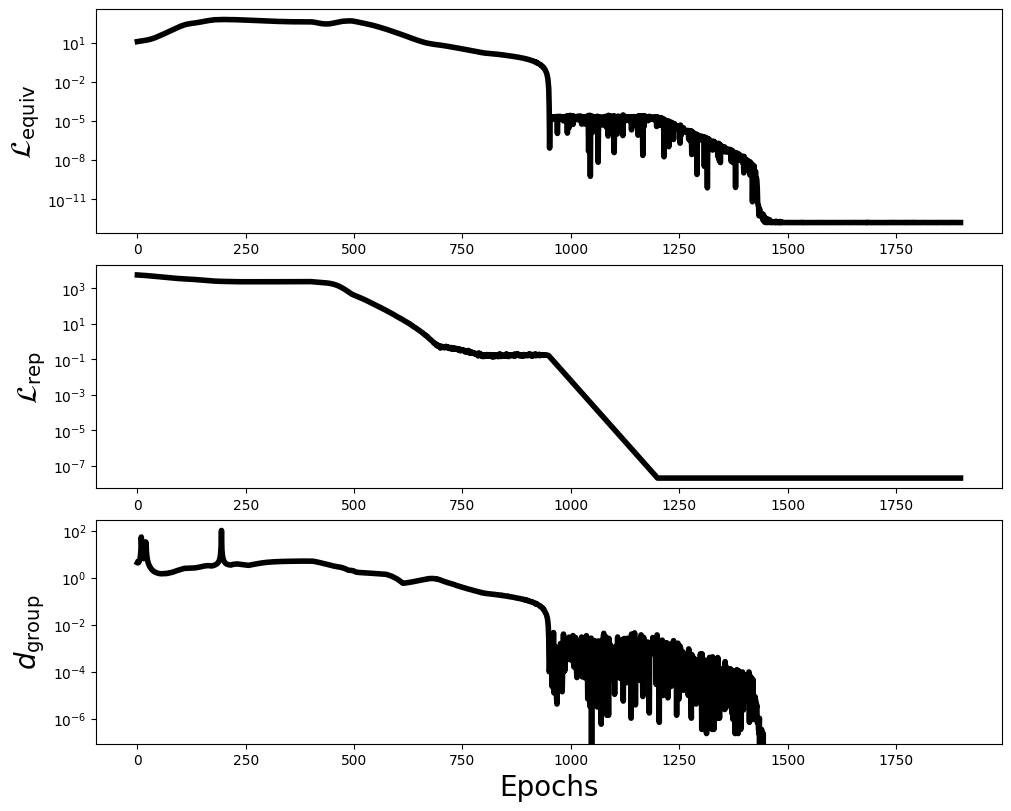

In [18]:
# Calculate group metric
history_dgroup = calculate_history_group_metric(history_Ws)

# Plot equivariance loss, repetition loss and group metric
fig = plt.figure(constrained_layout=True, figsize=(10,8))

gs = fig.add_gridspec(3,1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

ax1.set_ylabel(r'$\mathcal{L}_{\mathrm{equiv}}$',fontsize=20)
ax2.set_ylabel(r'$\mathcal{L}_{\mathrm{rep}}$',fontsize=20)
ax3.set_ylabel(r'$d_{\mathrm{group}}$',fontsize=20)
ax3.set_xlabel('Epochs',fontsize=20)

ax1.plot(range(epochs),history_Lequiv, linewidth=4, c='k')
ax2.plot(range(epochs),history_Lrep, linewidth=4, c='k')
ax3.plot(range(epochs),history_dgroup, linewidth=4, c='k')

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

plt.show()